# Обнаружение каверов музыкальных треков

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можно полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

В этом хакатоне предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Для решения задачи классификации треков по признаку кавер-некавер оценку качества будем производить метрикой F1.

**В ходе проекта:**
- изучим данные
- проведем предобработку
- подготовим выборки для обучения моделей. Преобразуем категориальные признаки для подготовки их к моделированию методом TargetEncoder. Стандартизируем диапазон функциональных возможностей входного набора данных с помощью StandardScaler. Организуем все эти методы в make_pipeline.
- обучим модели: RandomForestClassifier, XGBClassifier. Соотнесем с константной моделью. Для каждой модели подберем наилучшие гиперпараметры с помощью GridSearchCV.
- проанализируем время обучения и предсказания, и качество моделей.
- выберем лучшую модель, проверим её качество на тестовой выборке.

## Данные


### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

### Метаинформация

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

Целевой признак track_remake_type — метка может принимать значения ORIGINAL и COVER.

## Изучение данных

Подключим необходимые библиотеки:

In [2]:
pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=a38323253694af1f5b88994a3ec053716123205388cd8daa5e4fe160d68dfc2b
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import langid
import numpy as np
import nltk
import phik
import re
import seaborn as sns
import sys
import spacy
import xgboost as xgb

from lightgbm import LGBMClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from tqdm import notebook

import warnings
warnings.filterwarnings("ignore")

Преобразуем json-файлы в датафреймы:

In [ ]:
covers_data = pd.read_json('covers.json', lines= True)
lyrics_data = pd.read_json('lyrics.json', lines= True)
meta_data = pd.read_json('meta.json', lines= True)

Изучим данные, посмотрим на их содержание, форму, ключевые моменты:

In [ ]:
def get_data_analysis(data):
    display(data.head())
    print('\n')
    data.info()
    print('\n')
    #print(f'Кол-во дубликатов равно = {data.duplicated().sum()}')
    display(data.describe(include='object'))
    print('\n')
    #data.plot.hist(bins=30)
    #plt.show()
    print('\n', '========'*10)

In [ ]:
list_data = [covers_data, lyrics_data, meta_data]
for data in list_data:
    print (get_data_analysis(data))

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB




,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,eeb69a3cb92300456b6a5f4162093851,COVER
freq,38,1,67304





None


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB




,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,28fbafaf626c497d0d4d933b4f0d3f5b,Twenty-five years and my life is still\nI'm tr...,b891000882f4a612190142861b5c038b
freq,9,15,24





None


,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB




,track_id,title,language,isrc,genres
count,71768,71768,21969,71455,71768
unique,71768,45462,85,71283,232
top,c3b9d6a354ca008aa4518329aaa21380,Morena,EN,USTCF1018560,"[FOLK, LATINFOLK]"
freq,1,81,15322,3,18391





None


В датасетах с треками и их метаданными присутствуют пропуски у некоторых признаков. В датасете текстов песен присутствуют повторы id, как песен, так и треков. В датасете метаданных треков признак dttm имеет данные в формате Unix Timestamp, признак genres имеет данные в списках, коды в признаке isrc	имеют повторы, несмотря на то, что все треки уникальны в наборе.

In [ ]:
covers_data[covers_data['original_track_id'] == 'f3e5e9db509f9b6f6d93b9c38e4e1324']

,original_track_id,track_id,track_remake_type
211,f3e5e9db509f9b6f6d93b9c38e4e1324,f3e5e9db509f9b6f6d93b9c38e4e1324,ORIGINAL
243,f3e5e9db509f9b6f6d93b9c38e4e1324,9e20fd52b21566494b8d6586a39033c9,COVER
558,f3e5e9db509f9b6f6d93b9c38e4e1324,d71bd79936e69ffeb21ef6dd62e55b2e,COVER
2952,f3e5e9db509f9b6f6d93b9c38e4e1324,1dca7297005a6f9700e9eb43dd47a5e3,COVER
3907,f3e5e9db509f9b6f6d93b9c38e4e1324,214c5086fd618bc642260433c867f9c7,COVER
4385,f3e5e9db509f9b6f6d93b9c38e4e1324,28efa5567f2b3c090f311a3cb8805082,COVER
5828,f3e5e9db509f9b6f6d93b9c38e4e1324,18ad5f6948ce88882bf3791c22a3a53f,COVER
6676,f3e5e9db509f9b6f6d93b9c38e4e1324,ed541e2712a89d14b36170d912ef4698,COVER
7048,f3e5e9db509f9b6f6d93b9c38e4e1324,82aa19859b0f781fceca8b59de6b78ff,COVER
7053,f3e5e9db509f9b6f6d93b9c38e4e1324,04f227ff6ad073b4ac805d753d604337,COVER


In [ ]:
covers_data['original_track_id'].value_counts()

f3e5e9db509f9b6f6d93b9c38e4e1324    38
17a163f6ab3de102b49599f5577866fc    32
deb9b9598176a0bab1212d430b10bd04    31
53a04991308c2cc9179fdd401fea83a3    30
eeb69a3cb92300456b6a5f4162093851    25
                                    ..
f90f1b7cdca3bb662457cbfba5bd1e79     1
404ac4ea6ae146e12b7c2e3fd7dc7b3f     1
8f82fd26ef9fee54c9f15b66db50cb86     1
5d6d492e2a0151846b2562ce9e4c8be7     1
7b0f6ff24137be50cf5ea5f82d789448     1
Name: original_track_id, Length: 4468, dtype: int64

In [ ]:
covers_data[pd.isnull(covers_data['original_track_id'])].groupby(['track_remake_type']).count()

,original_track_id,track_id
track_remake_type,,
COVER,0,66776


Признак original_track_id объединяет группу разных треков. Внутри группы есть один оригинал. Есть группы только с одним треком. Присутствуют данные без указания original_track_id, все они с меткой 'COVER'.

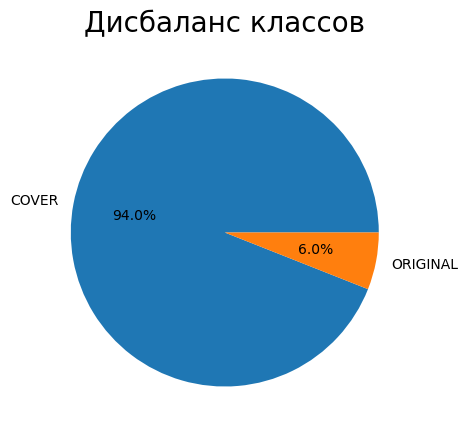

In [ ]:
covers_data['track_remake_type'].value_counts().plot(kind='pie', figsize=(10,5), autopct='%1.1f%%')
plt.title('Дисбаланс классов', fontsize=20)
plt.ylabel('');

Присутствует дисбаланс целевого признака.

**Выводы:** Присутствующие пропуски в датасетах с треками и их метаданными нужно будет обработать. Признак dttm в датасете метаданных треков перевести из Unix Timestamp в Datetime, из признака genres данные в списках нужно преобразовать в строковые. Учесть при подготовке обучающей и тестовой выборок дисбаланс в целевом признаке.

## Предобработка

Целью предобработки является очищение данных от неизвестных, преобразование типов объектов и объединение признаков из разных датафреймов в один.

Преобразуем временной признак:

In [ ]:
meta_data['dttm'] = pd.to_datetime(meta_data['dttm'], unit='ms')

Вынесем в отдельные признаки день, месяц и год даты появления информации о треке:

In [ ]:
meta_data['year'] = meta_data['dttm'].dt.year
meta_data['day'] = meta_data['dttm'].dt.day
meta_data['month'] = meta_data['dttm'].dt.month
meta_data.head()

,track_id,dttm,title,language,isrc,genres,duration,year,day,month
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,2021.0,16.0,12.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,2021.0,24.0,11.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,2021.0,24.0,11.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,2021.0,24.0,11.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,2021.0,24.0,11.0


In [ ]:
meta_data['year'].value_counts()

2021.0    28932
2022.0    13454
2020.0     9174
2019.0     6034
2018.0     2029
2017.0     1672
2012.0     1665
2013.0     1514
2015.0     1422
2014.0     1348
2011.0     1295
2023.0     1198
2016.0     1016
2010.0      856
2009.0      159
Name: year, dtype: int64

Посмотрим на признак language, у него много пропусков, попробуем восстановить:

In [ ]:
meta_data['language'].value_counts(dropna=False).to_frame().rename(columns = {'language':'count', 'index':'language'})

,count
None,49800
EN,15322
ES,1747
RU,1558
IT,907
...,...
BM,1
TN,1
AB,1
NY,1


Восстанавливать язык будем с помощью библиотеки langid по текстам песен, пометим цифровые названия как неизвестными, по умолчанию английский язык:

In [ ]:
meta_data = meta_data.dropna(subset='title')
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71768 entries, 0 to 71768
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
 7   year      71768 non-null  float64       
 8   day       71768 non-null  float64       
 9   month     71768 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 6.0+ MB


In [ ]:
def change_int_to_unk(string):
    if string.isdigit():
        return 'Unknown'
    else:
        return string

meta_data['title'] = meta_data['title'].apply(change_int_to_unk)

In [ ]:
meta_data['language_new'] = 'en'
for i in notebook.tqdm(range(len(meta_data))):
    meta_data['language_new'][i] = langid.classify(meta_data['title'][i])[0]

Признак genres представлен в виде списка, попробуем избавиться от него и оставить один текст:

In [ ]:
meta_data = meta_data.dropna(subset='genres')
meta_data.head()

,track_id,dttm,title,language,isrc,genres,duration,year,day,month,language_new
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,2021.0,16.0,12.0,en
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,2021.0,24.0,11.0,en
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,2021.0,24.0,11.0,es
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,2021.0,24.0,11.0,lt
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,2021.0,24.0,11.0,es


In [ ]:
def get_str_from_list(lst):
    string = ''
    for el in lst:
        string += str(el)
        string += ''
    return string

meta_data['genres'] = meta_data['genres'].apply(get_str_from_list)
meta_data['genres'].head()

0            DANCE
1      ELECTRONICS
2    FOLKLATINFOLK
3    FOLKLATINFOLK
4    FOLKLATINFOLK
Name: genres, dtype: object

Объединим два датафрейма треков и их метаданных, объединить с текстами не представляется возможным ввиду отсутствия уникальных идентификаторов, дублированные треки могут негативно сказаться на результате работы модели:

In [ ]:
general_data = pd.merge(covers_data, meta_data, on='track_id')
general_data.head(10)

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,year,day,month
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,ROCKALLROCK,187220.0,2009.0,11.0,11.0
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,ROCKALLROCK,137780.0,2009.0,11.0,11.0
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,POPFOLKLATINFOLK,216840.0,2009.0,21.0,9.0
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,FOREIGNRAPRAP,179660.0,2009.0,16.0,11.0
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER,2009-09-17 20:00:00,Extraball,EN,FR8Q10900116,ELECTRONICS,212620.0,2009.0,17.0,9.0
5,None,4da9d7b6d119db4d2d564a2197798380,COVER,2009-09-17 20:00:00,Can't Buy Me Love,EN,USGR10110569,JAZZVOCALJAZZ,158950.0,2009.0,17.0,9.0
6,None,2bf283c05b601f21364d052ca0ec798d,COVER,2009-09-17 20:00:00,She's Leaving Home,None,USGR19900418,JAZZ,356070.0,2009.0,17.0,9.0
7,None,5eb13cb69b6e20dd7a42030f5936a9dc,COVER,2017-02-28 21:00:00,Warning,EN,GBAJE7000082,CLASSICMETALMETAL,628340.0,2017.0,28.0,2.0
8,None,109f91266ef89cc3690079b28abfe9a3,COVER,2009-08-10 17:32:06,"Evil Woman, Don't Play Your Games With Me",EN,GBAJE7000080,CLASSICMETALMETAL,202990.0,2009.0,10.0,8.0
9,76c538125fc5c9ec6ad1d05650a57de5,76c538125fc5c9ec6ad1d05650a57de5,ORIGINAL,2009-11-12 21:00:00,Just A Lil Bit,EN,USIR10500279,FOREIGNRAPRAP,239180.0,2009.0,12.0,11.0


Удалим объекты с пропусками:

In [ ]:
general_data = general_data.dropna(subset=['track_remake_type', 'title', 'genres', 'duration'])

Удалим признаки, которые нам не понадобятся в решении задачи. Идентификаторы нам не помогут, язык мы переопределили, из дат создали новые признаки:

In [ ]:
general_data = general_data.drop(['original_track_id', 'track_id', 'dttm', 'isrc', 'language'], axis=1)

In [ ]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71597 entries, 0 to 71596
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  71597 non-null  object 
 1   title              71597 non-null  object 
 2   genres             71597 non-null  object 
 3   duration           71597 non-null  float64
 4   year               71597 non-null  float64
 5   day                71597 non-null  float64
 6   month              71597 non-null  float64
 7   language_new       71597 non-null  object 
dtypes: float64(4), object(4)
memory usage: 4.9+ MB


Промасштабируем и закодируем данные. Используем StandardScaler для числовых признаков и TargetEncoder для категориальных. Создадим препроцессор. Для целевого признака используем get_dummies.

In [ ]:
general_data['track_remake_type'] = pd.get_dummies(general_data['track_remake_type'],  drop_first=True)
general_data.tail()

,track_remake_type,title,genres,duration,year,day,month
71592,1,"Милый, прощай",POPRUSPOP,178980.0,2023.0,28.0,9.0
71593,0,Habits (Stay Hight),ELECTRONICS,149570.0,2023.0,1.0,10.0
71594,0,Arcade,FOREIGNBARDBARD,201580.0,2023.0,5.0,10.0
71595,1,Май,RUSRAPRAP,156870.0,2023.0,5.0,10.0
71596,1,Не улетай,POPRUSPOP,148500.0,2023.0,5.0,10.0


In [ ]:
num_col = ['duration', 'day', 'year', 'month']
cat_col = ['title', 'genres', 'language_new']

num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(TargetEncoder())

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)
                   ]
)

Разобьем данные на обучающую и тестовую выборки, используя параметр stratify по таргету для сохранения пропорций в данных:

In [ ]:
state = 42
features = general_data.drop(['track_remake_type'], axis=1)
target = general_data['track_remake_type']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=state, stratify=target)

## Обучение моделей

Напишем функцию для поиска наилучших параметров моделей посредством GridSearchCV:

In [ ]:
def search_parameters(preprocessor, model, param_grid, features_train, target_train):
    pipe = make_pipeline(preprocessor, model)

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(features_train, target_train)

    time_table = pd.DataFrame(grid_search.cv_results_)

    print('Наилучший результат метрики {} с параметрами: {}'.format(grid_search.best_score_, grid_search.best_params_))
    print('Временные показатели: обучение - {:.1f}s, предсказания - {:.1f}s'.format(time_table.loc[0, 'mean_fit_time'], time_table.loc[0, 'mean_score_time']))

Обучим модель с помощью алгоритма RandomForestClassifier со взвешиванием классов:

In [ ]:
model_rfc = RandomForestClassifier(random_state=state)

param_grid_rfc = {'randomforestclassifier__n_estimators' : [100,300,1000],
                  'randomforestclassifier__max_depth'    : [4,6,8],
                  'randomforestclassifier__class_weight' : ['balanced']
                 }

search_parameters(preprocessor, model_rfc, param_grid_rfc, features_train, target_train)

Наилучший результат метрики 0.6187282964549897 с параметрами: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300}
Временные показатели: обучение - 8.3s, предсказания - 0.8s


Обучим модель с помощью алгоритма XGBClassifier со взвешиванием классов:

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=state)

param_grid_xgb = {'xgbclassifier__n_estimators' : [50, 500, 1000],
                  'xgbclassifier__learning_rate' : [0.1, 0.05],
                  'xgbclassifier__max_depth': [10, 15],
                  'xgbclassifier__min_child_weight': [3, 5, 7],
                  'xgbclassifier__class_weight' : ['balanced']
                 }

search_parameters(preprocessor, model_xgb, param_grid_xgb, features_train, target_train)

Наилучший результат метрики 0.7209550703670146 с параметрами: {'xgbclassifier__class_weight': 'balanced', 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 50}
Временные показатели: обучение - 1.5s, предсказания - 0.3s


**Выводы:** Модель, обученная алгоритмом XGBClassifier, обучилась почти в 4 раза быстрее модели, обученной алгоритмом RandomForestClassifier, а также лучше оказался и результат метрики F1=0.72.

## Тест

Для оценки адекватности моделей обучим константную модель:

In [ ]:
dummy_model = DummyClassifier(strategy='stratified')
pipe_dummy = make_pipeline(preprocessor, dummy_model)
pipe_dummy.fit(features_train, target_train)

score = pipe_dummy.score(features_test, target_test)

print(score)

0.8875977653631285


Проверим качество выбранной модели на тестовой выборке:

In [ ]:
model_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=3,
    class_weight='balanced',
    random_state=state
)
pipe_xgb = make_pipeline(preprocessor, model_xgb)
pipe_xgb.fit(features_train, target_train)
predictions = pipe_xgb.predict(features_test)
score_report = classification_report(target_test, predictions)

print(score_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16827
           1       0.76      0.68      0.72      1073

    accuracy                           0.97     17900
   macro avg       0.87      0.83      0.85     17900
weighted avg       0.97      0.97      0.97     17900



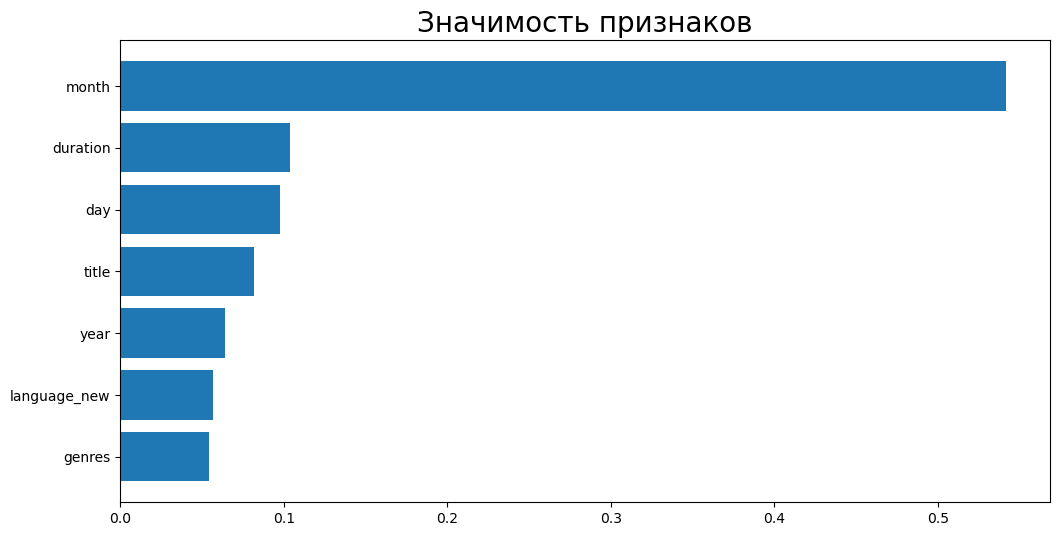

In [ ]:
feature_importance = pipe_xgb[1].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Значимость признаков', fontsize=20);

Наиболее значимым модель считает признак month.

0.9680704705541636

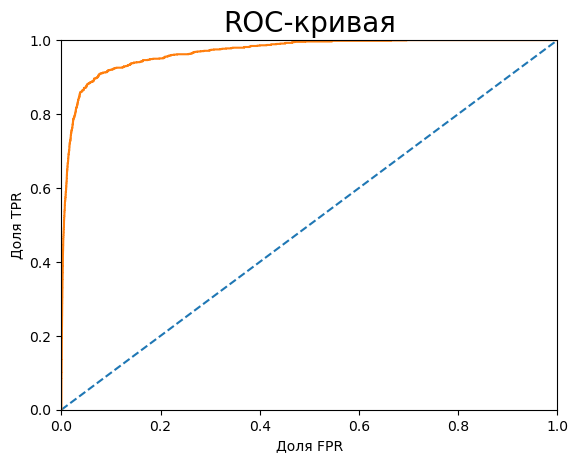

In [ ]:
#построим ROC-кривую
probabilities_test = pipe_xgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
display(auc_roc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()


plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Доля FPR')
plt.ylabel('Доля TPR')
plt.title('ROC-кривая', fontsize=20)
plt.show()

**Выводы:**
Для проверки тестовой выборки выбрана модель с самым высоким значением метрики F1, это модель XGBClassifier. Значение метрики не превысило значения F1=0.71.

## Итоговые выводы:

Целью проекта было разработать решение, способное классифицировать треки по признаку кавер-некавер.

Была проведена предобработка данных:
- удалили неинформативные признаки
- заполнили пропущенные значения
- устранили неподходящий тип данных
- подготовили выборки для обучения моделей
- преобразовали категориальные признаки для подготовки их к моделированию методом TargetEncoder. Стандартизировали диапазон числовых значений с помощью StandardScaler.


Для подбора моделей были использованы алгоритмы:
1. RandomForestClassifier
2. XGBClassifier

С использованием GridSearchCV были подобраны наилучшие параметры для наибольшего значения метрики F1.

Проанализировали время обучения и предсказания.

Обучение модели с учётом дисбаланса привело к следующим результатам: максимально достигнутое значение F1-меры=0,72 обеспечила модель XGBClassifier с параметрами: n_estimators=1000, learning_rate=0.05, max_depth=10, min_child_weight=3, class_weight='balanced'.

На тестовой выборке мы получили F1=0,71, Accuracy=0,97.

ROC-кривая показывает нам что преобладающий класс модель предсказывает гораздо лучше. AUC_ROC=0.97.

Для улучшения качества предсказаний можно сделать ресемплинг, дополнить датасет информативными признаками, провести дополнительный подбор гиперпараметров, пересмотреть методы кодирования.

## Задача кластеризации


In [5]:
pip install bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59055 sha256=bc4be5a7cfe2d05b69a76a9b3a9b128c41315a22c003ee50999fe455f0619ceb
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit


In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [28]:
import string
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from tqdm import notebook

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Загружаем и предобрабатываем данные

In [7]:
covers = pd.read_json("/content/covers.json", lines = True)
lyrics = pd.read_json("/content/lyrics.json", lines = True)
meta = pd.read_json("/content/meta.json", lines = True)

In [8]:
lyr_cov = pd.merge(covers, lyrics, on='track_id', how='right')

In [9]:
lyr_cov.head()

,original_track_id,track_id,track_remake_type,lyricId,text
0,1c4b1230f937e4c548ff732523214dcd,1c4b1230f937e4c548ff732523214dcd,ORIGINAL,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n..."
1,None,0faea89b0d7d6235b5b74def72511bd8,COVER,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...
2,9c6dc41d5ccd9968d07f055da5d8f741,9c6dc41d5ccd9968d07f055da5d8f741,ORIGINAL,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...
3,bfd04a73e9cffdf0e282c92219a86ea1,bfd04a73e9cffdf0e282c92219a86ea1,ORIGINAL,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...
4,8d70930d09cd239c948408d1317d8659,8d70930d09cd239c948408d1317d8659,ORIGINAL,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a..."


In [10]:
dtypes = pd.DataFrame(lyr_cov.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=lyr_cov.nunique().sort_values(ascending=True)

dtypes["Null Values"]=lyr_cov.isnull().sum()

dtypes["% null Values"]=lyr_cov.isnull().sum()/len(lyr_cov)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
original_track_id,object,2824,7815,0.684685
track_remake_type,object,2,317,0.027773
track_id,object,10277,0,0.000000
lyricId,object,10915,0,0.000000
text,object,10644,0,0.000000


In [11]:
lyr_cov = lyr_cov.dropna(subset='track_remake_type')

Очистим текстовые данные, приведем их в удобный формат, закодируем с помощью tf-idf

In [12]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)) for w in word_list])
    return lemmatized_output

def clear_text(text):
    text = re.sub(r"[^a-zA-Z ]", ' ', text)
    text = text.split()
    return " ".join(text)

In [14]:
sample = lyr_cov.groupby('track_remake_type', group_keys=False)['text'].apply(lambda x: x.sample(frac=0.2))
text = list(sample.values)

In [29]:
for i in notebook.tqdm(range(len(text))):
    text[i] = clear_text(lemmatize(text[i]))
tfidf_vect = TfidfVectorizer()
matrix_text = tfidf_vect.fit_transform(text)
df_text = pd.DataFrame.sparse.from_spmatrix(matrix_text)

  0%|          | 0/2219 [00:00<?, ?it/s]

In [30]:
matrix_text

<2219x16148 sparse matrix of type '<class 'numpy.float64'>'
	with 137485 stored elements in Compressed Sparse Row format>

In [31]:
matrix = df_text.to_numpy()
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Columns: 16148 entries, 0 to 16147
dtypes: Sparse[float64, 0](16148)
memory usage: 1.6 MB


Сделаем две матрицы - меткой целевого признака и без

In [33]:
df = df_text.join(lyr_cov['track_remake_type'])

In [34]:
df['track_remake_type'] = pd.get_dummies(df['track_remake_type'], drop_first=True)

In [35]:
unmarked = df.drop('track_remake_type', axis=1)

In [36]:
unmarked = unmarked.to_numpy()

Затем преобразуем в TSNE и посмотрим на них

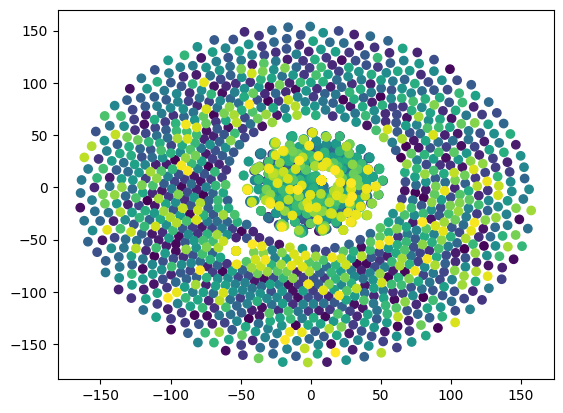

In [45]:
# Определяем модель и скорость обучения
model = TSNE(learning_rate=86)
# Обучаем модель
transformed = model.fit_transform(unmarked)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=range(2219)) #sample['track_remake_type']
plt.show()


Попробуем подобрать оптимальные гиперпараметры модели DBSCAN метрикой silhouette_score

In [ ]:
best_eps = 0
best_sc = 0
best_min = 0

for eps in notebook.tqdm(np.arange(0.01, 0.5, 0.01)):
  try:
    for min in  range(1, 102, 10):
      get_clusters = DBSCAN(eps=eps, min_samples=min).fit_predict(transformed)
      sc = metrics.silhouette_score(transformed, get_clusters)

      if sc > best_sc:
        best_sc = sc
        best_eps = eps
        best_min = min
  except: pass
best_eps, best_sc, best_min

In [ ]:
get_clusters = DBSCAN(eps=best_eps, min_samples=best_min).fit_predict(transformed)
sc = metrics.silhouette_score(transformed, get_clusters)

len(set(get_clusters)), sc

In [ ]:
u_labels = np.unique(get_clusters)

for i in u_labels:
    plt.scatter(transformed[get_clusters == i , 0] , transformed[get_clusters == i , 1])
plt.legend()
plt.show();

## Вывод:
К сожалению, подбор гиперпараметров занимает много времени и к тому же запрашивает хорошего технического оснащения. Поэтому на данном этапе предлагается только прототип решения, на основе которого возможно разработать модель, удовлетворяющую запросам бизнеса.